In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.integrate import quad

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1.5)
sns.set_palette("pastel")

##  $a = a(\log{M_{bh}}, \log{\sigma})$

/tmp/ipykernel_747/2926582598.py:14: RuntimeWarning: divide by zero encountered in divide
  sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
/tmp/ipykernel_747/2926582598.py:16: RuntimeWarning: divide by zero encountered in divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_747/2926582598.py:17: RuntimeWarning: invalid value encountered in multiply
  return prefactor * exp_term * jacobian


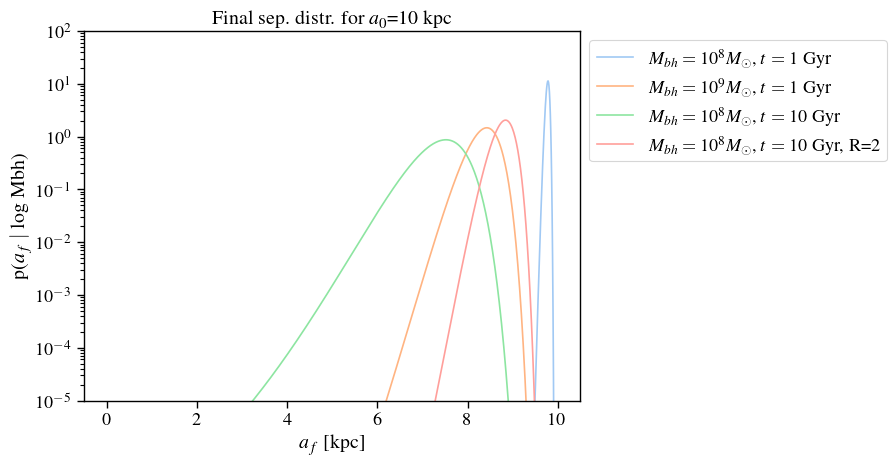

In [4]:
a0 = 10
a = np.linspace(0,a0,1000)
# mbh-sigma constants
epsilon = 0.38
beta = 5.64
alpha = 8.32
# tdf constants
coulomb_log = 3
gamma = 19/ coulomb_log / 25 / 200 * 1e8
def pa_sigma(a,mbh,t,a0,R=1):
     """p(a|mbh) for a = a(mbh, sigma)"""
     logmbh = np.log10(mbh)
     prefactor = 1/(np.sqrt(2*np.pi)*epsilon/beta) 
     sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
     exp_term = np.exp(-(np.log10(sigma_star) - 1/beta*logmbh + alpha/beta)**2 / (2*epsilon**2/beta**2))
     jacobian = 2*a/(a0**2-a**2)/np.log(10)
     return prefactor * exp_term * jacobian

plt.figure()
plt.plot(a,pa_sigma(a,mbh = 1e8,t = 1, a0 = a0),label='$M_{bh}=10^8M_\odot$,~$t=1$ Gyr')
plt.plot(a,pa_sigma(a,mbh = 1e9,t = 1, a0 = a0),label='$M_{bh}=10^9M_\odot$,~$t=1$ Gyr')
plt.plot(a,pa_sigma(a,mbh = 1e8,t = 10, a0 = a0),label='$M_{bh}=10^8M_\odot$,~$t=10$ Gyr')
plt.plot(a,pa_sigma(a,mbh = 1e8,t = 10, a0 = a0, R = 2),label='$M_{bh}=10^8M_\odot$,~$t=10$ Gyr, R=2')
plt.title(rf"Final sep. distr. for $a_0$={a0} kpc")
plt.xlabel("$a_{f}$ [kpc]")
plt.ylabel("p($a_{f}$ $|$ log Mbh)")
plt.yscale('log')
plt.ylim((1e-5,1e2))
plt.legend(bbox_to_anchor=(1,1));

Check normalization. Note that scipy.quad cannot integrate over a very large range. (quad samples the integration interval and might miss peaks)

In [5]:
quad(pa_sigma, 0, a0, args=(1e8,1,a0,2))

(1.0000000000000038, 1.0515691091928172e-09)

##  $a = a(\log{M_{bh}}, \log{\sigma}, a_0)$

### uniform prior on $a_0$

/tmp/ipykernel_747/2926582598.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
/tmp/ipykernel_747/2926582598.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_747/2926582598.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_747/492133364.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,R,amin,amax))[0])


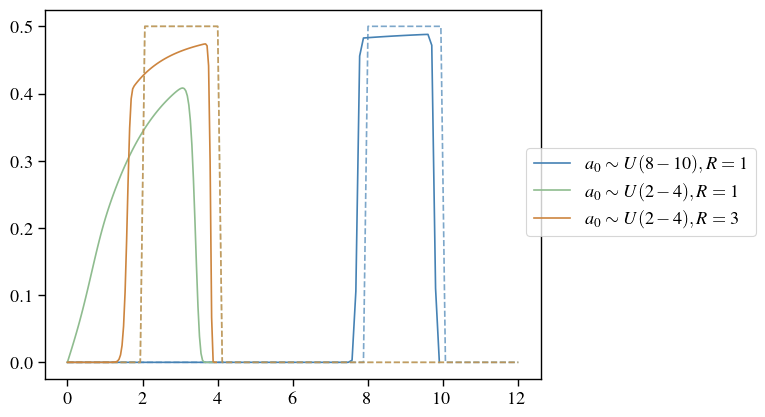

In [6]:
def p_a0_uniform(amin,amax):
    """define uniform prior over (amin,amax)"""
    return 1/(amax-amin)

def pa_sigma_a0_unif_integrand(a0, a, mbh, t, R, amin, amax):
    """return the integrand, i.e. p(a|mbh,sigma,a)*p(sigma|mbh)*p(a|mbh)"""
    return pa_sigma(a, mbh, t, a0, R) * p_a0_uniform(amin, amax)

def pa_sigma_a0_unif(amin,amax,mbh,t,R):
    """for each af(a) value, integrate over all a0"""
    a = np.linspace(0,amax,100)
    p = []
    for a_ in a:
        alower = np.max([a_,amin])
        p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,R,amin,amax))[0])
    return a, p

def plot_pa_unif(amin,amax,mbh,t,R,ax,clr):
    # function for plotting pa, uniform a0
    # find p(a|mbh)
    a,p = pa_sigma_a0_unif(amin,amax,mbh,t,R)
    # calculate prior over large range for pretty plot
    unif = lambda x,amin,amax: 0 if (x<amin) or (x> amax) else 1/(amax-amin)
    apr = np.linspace(0,12,100)
    pr = [unif(a_,amin,amax) for a_ in apr]
    # plot
    ax.plot(a,p,c=clr,label=rf"$a_0\sim U({{{amin}}}-{{{amax}}}),R={R}$")
    ax.plot(apr,pr,linestyle="--",c=clr,alpha=0.7)

fig,ax = plt.subplots()
plot_pa_unif(8,10,1e8,1,1,ax,"steelblue")
plot_pa_unif(2,4,1e8,1,1,ax,"darkseagreen")
plot_pa_unif(2,4,1e8,1,3,ax,"peru")
fig.legend(loc="center right",bbox_to_anchor=(1.25,0.5));


Evolve individually and check with p(a)

/tmp/ipykernel_747/275520913.py:7: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
/tmp/ipykernel_747/2926582598.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
/tmp/ipykernel_747/2926582598.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_747/2926582598.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_747/492133364.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,R,amin,amax))[0])


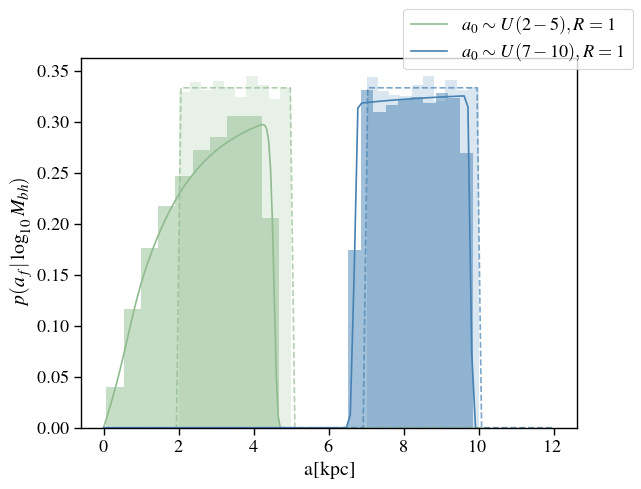

In [29]:
def af_from_a0(a0,mbh,t,R):
    logmbh = np.log10(mbh)
    N = len(a0)
    # sample sigma
    logsigma = np.random.normal(loc=1/beta*logmbh-alpha/beta,scale=epsilon/beta,size=N)
    sigma = 10**logsigma*200
    af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
    return af

def monte_carlo_unif_a0(amin, amax, mbh=1e8, t=1, R=1, N=10000):
    # sample a0
    a0 = np.random.uniform(amin,amax,N)
    af = af_from_a0(a0,mbh,t,R)
    return a0,af
   
def plot_mc(ax,clr,a0,af):
    ax.hist(af,density=True,color=clr,alpha=0.5)
    ax.hist(a0,density=True,color=clr,alpha=0.2)
    
a0S,afS = monte_carlo_unif_a0(amin=2, amax=5)
a0L,afL = monte_carlo_unif_a0(amin=7, amax=10)

fig,ax = plt.subplots()
plot_pa_unif(2,5,1e8,1,1,ax,"darkseagreen")
plot_mc(ax,"darkseagreen",a0S,afS)

plot_pa_unif(7,10,1e8,1,1,ax,"steelblue")
plot_mc(ax,"steelblue",a0L,afL)

ax.set_xlabel("a[kpc]")
ax.set_ylabel(r"$p(a_f|\log_{10}{M_{bh}})$")
fig.legend();

Try KL divergence

/tmp/ipykernel_747/275520913.py:7: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))


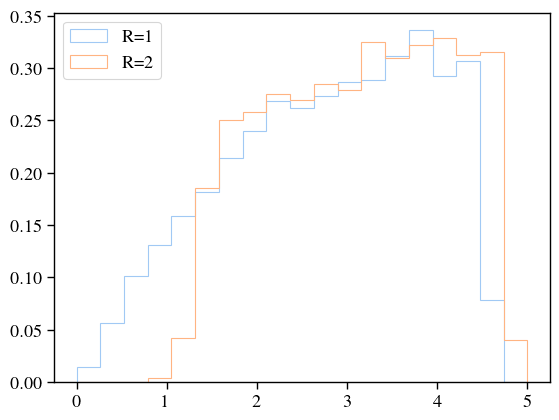

In [40]:
# create af from 2 diff rates
a0_r1,af_r1 = monte_carlo_unif_a0(amin=2, amax=5, R=1)
a0_r2,af_r2 = monte_carlo_unif_a0(amin=2, amax=5, R=2)
# visualize
binz = np.linspace(0,5,20)
p,a,_ = plt.hist(af_r1,histtype='step',density=True,bins=binz,label='R=1')
q,a,_ = plt.hist(af_r2,histtype='step',density=True,bins=binz,label="R=2")
plt.legend();

/tmp/ipykernel_747/275520913.py:7: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by zero encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: invalid value encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by zero encountered in log10
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: invalid value encountered in multiply
  d = q*(np.log10(q/p))


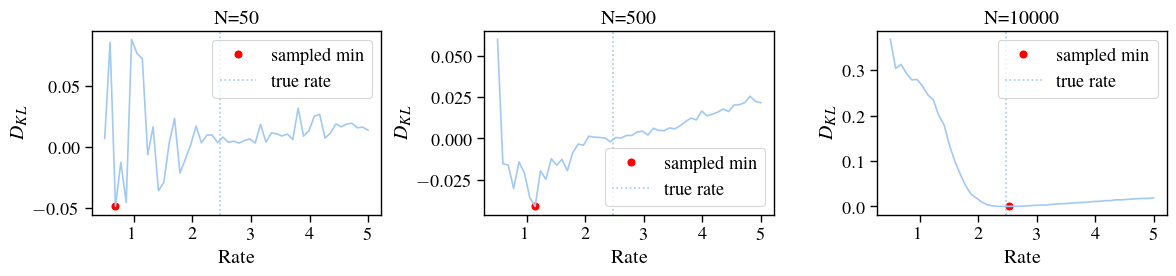

In [67]:
def div_KL(p,q):
    """calculate KL divergence given pdf p and q"""
    d = q*(np.log10(q/p))
    div = np.sum(d[np.isfinite(d)])
    return div

def KL_mock(trueRate, sampleSize, amin=2, amax=5, mbh=1e8,t=1):
    """generate mock data and do KL test for sampled rates
        params:
            trueRate: the timescale rate to produce mock observed data
            sampleSize: mock sample size"""
    # generate mock observations
    a0_obs,af_obs = monte_carlo_unif_a0(amin, amax, R=trueRate, N=sampleSize)
    # turn into pdf
    binz = np.linspace(0,np.max(af_obs)+1,10)
    p_obs,_ = np.histogram(af_obs,density=True,bins=binz)

    # sample rates
    rates = np.linspace(5,50,50)*0.1
    dKLs = []
    for r in rates:
        # predict af
        af_pred = af_from_a0(a0=a0_obs,mbh=mbh,t=t,R=r)
        # convert to pdf
        p_pred,_ = np.histogram(af_pred,density=True,bins=binz)
        # calculate KL div
        dKL = div_KL(p_obs,p_pred)
        dKLs.append(dKL)
    return rates, dKLs

def plot_KL_curve(ax,rates,dKLs,trueRate,sampleSize):
    # find lowest dKL
    min_ind = np.argmin(dKLs)
    ax.plot(rates[min_ind],dKLs[min_ind],"ro",label='sampled min')
    # plot
    ax.plot(rates,dKLs)
    ax.set_xlabel("Rate")
    ax.set_ylabel("$D_{KL}$")
    ax.axvline(trueRate,linestyle=":", label='true rate')
    ax.set_title(f"N={sampleSize}")
    ax.legend();


# calculte and plot
fig,ax = plt.subplots(1,3,figsize=(12,3))
for a,size in zip(ax, [50,500,10000]):
    rates, dKLs = KL_mock(trueRate=2.47, sampleSize=int(size))
    plot_KL_curve(a,rates, dKLs, 2.47, size)
fig.tight_layout();

add bootstrap

In [130]:
def KL_mock_with_bootstrap(trueRate, sampleSize, numboot, amin=2, amax=5, mbh=1e8,t=1):
    """generate mock data and do KL test for sampled rates
        params:
            trueRate: the timescale rate to produce mock observed data
            sampleSize: mock sample size"""
    # generate mock observations
    a0_obs_all,af_obs_all = monte_carlo_unif_a0(amin, amax, R=trueRate, N=sampleSize)
    df = pd.DataFrame([a0_obs_all,af_obs_all],index=['a0','af']).T
    # sample rates
    rates = np.linspace(5,50,50)*0.1
    # resample
    dkl_boot = []
    for i in range(numboot):
        df_b = df.sample(n=sampleSize,replace=True)
        # turn into pdf
        a0_obs,af_obs = df_b.a0.values, df_b.af.values
        binz = np.linspace(0,np.max(af_obs)+1,10)
        p_obs,_ = np.histogram(af_obs,density=True,bins=binz)

        # calculate div for each predicted af
        dKLs = []
        for r in rates:
            # predict af
            af_pred = af_from_a0(a0=a0_obs,mbh=mbh,t=t,R=r)
            # convert to pdf
            p_pred,_ = np.histogram(af_pred,density=True,bins=binz)
            # calculate KL div
            dKL = div_KL(p_obs,p_pred)
            dKLs.append(dKL)
        dkl_boot.append(dKLs)
    return rates, dkl_boot

def plot_KL_curve(ax,rates,dKLs,trueRate,sampleSize):
    # find lowest dKL
    min_ind = np.argmin(dKLs)
    ax.plot(rates[min_ind],dKLs[min_ind],"ro",label='sampled min')
    # plot
    ax.plot(rates,dKLs)
    ax.set_xlabel("Rate")
    ax.set_ylabel("$D_{KL}$")
    ax.axvline(trueRate,linestyle=":", label='true rate')
    ax.set_title(f"N={sampleSize}")
    ax.legend();



# # plot
# fig,ax = plt.subplots(1,3,figsize=(12,3))
# for a,size in zip(ax, ):
#     [a.plot(rates,bootdf[i],c='darkseagreen',alpha=0.5) for i in bootdf.columns]
#     a.axvline(2.47, label='true rate')
#     a.set_xlabel("Rate")
#     a.set_ylabel("$D_{KL}$")
#     a.set_title(f"N={size}")
#     a.legend()
# fig.tight_layout();

In [164]:
sampleSizes = [50,500,1000,10000]
alldat = [] # indexed by sample size
for sampsize in sampleSizes:
    rates, dkl_boot = KL_mock_with_bootstrap(trueRate=2.47,sampleSize=sampsize,numboot=500)
    # each col = a bootstrap sample
    bootdf = pd.DataFrame(dkl_boot).T
    alldat.append(bootdf)
# each ind = a sample size
alldf = pd.concat(alldat,axis=1,keys=sampleSizes)
# find rate that minimizes KL
min_rates = []
for sampsize in sampleSizes:
    min_locs = alldf[sampsize].to_numpy().argmin(axis=0)
    min_rates.append(rates[min_locs])

/tmp/ipykernel_747/275520913.py:7: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by zero encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: invalid value encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by zero encountered in log10
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: invalid value encountered in multiply
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/275520913.py:7: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by zero encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: invalid value encountered in divide
  d = q*(np.log10(q/p))
/tmp/ipykernel_747/1664866146.py:3: RuntimeWarning: divide by 

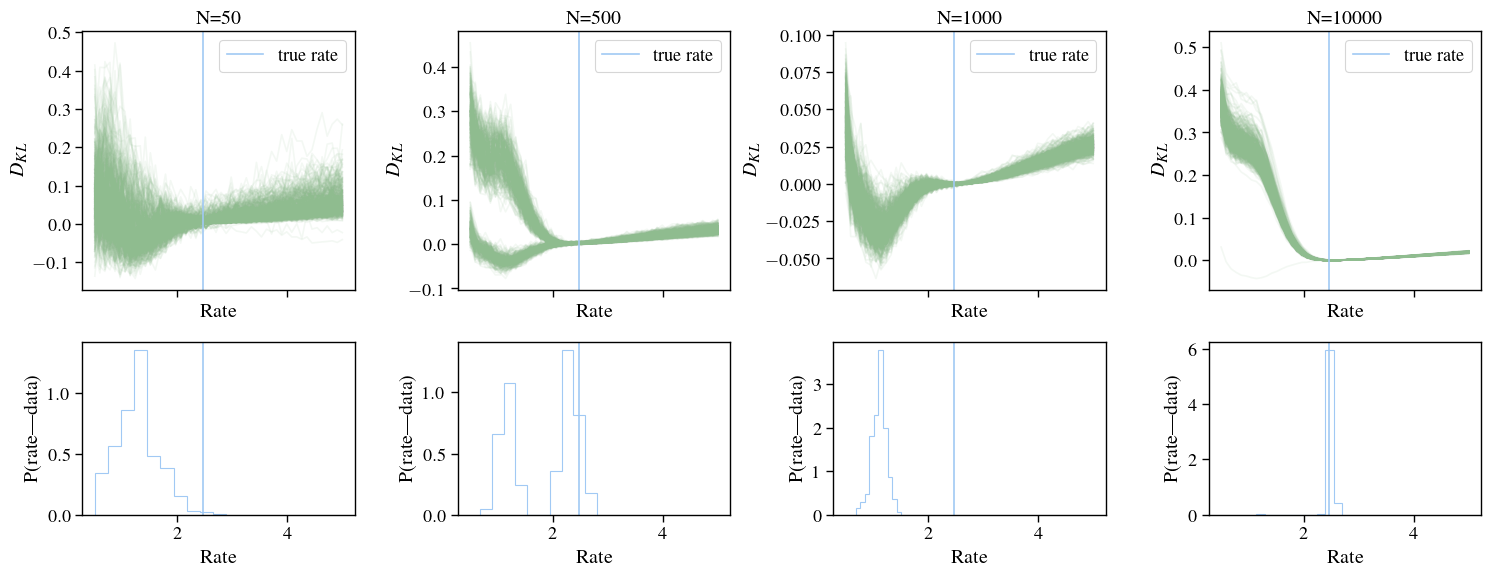

In [167]:
# plot
fig,ax = plt.subplots(2,4,figsize=(15,6),height_ratios=[1.5,1],sharex=True)
for a,b,sampsize,minrate in zip(ax[0,:], ax[1,:], sampleSizes,min_rates):
    [a.plot(rates,alldf[sampsize][i],c='darkseagreen',alpha=0.1) for i in alldf[sampsize].columns]
    a.axvline(2.47, label='true rate')
    a.set_xlabel("Rate")
    a.set_ylabel("$D_{KL}$")
    a.set_title(f"N={sampsize}")
    a.legend()

    b.hist(minrate,density=True,histtype='step')
    b.axvline(2.47)
    b.set_xlabel("Rate")
    b.set_ylabel("P(rate|data)")
    
fig.tight_layout();

Check that analytical solution matches numerical. 
Initially I plugged in a wrong formula to mathematica and got a closed form solution. But the correct integral does not have a closed form for the uniform $p(a_0)$ case

In [8]:
# from scipy.special import erf
def unif_anlt(a,mbh,t,a1,a2):
    # defind constants
    c0 = 2*a/(a2-a1)/np.log(10)/(np.sqrt(2*np.pi)*epsilon/beta)
    c1 = mbh*t/gamma/200
    c2 = 1/beta*np.log10(mbh) - alpha/beta
    c3 = 1/(2*epsilon**2/beta**2)
    c4 = c0 * (-np.log(10)/2)
    # calculate upper and lower limit after substitution
    U = np.log10(c1/(a2**2-a**2))
    al = np.array([np.max([a_,a1]) for a_ in a])
    L = np.log10(c1/(al**2-a**2))
    # the evaluated integral. from here down is not correct
    def f(c1,c2,c3,X,a):
        """this is not wrong. I plugged in the wrong integrand 
            to mathematica and got this"""
        term1 = np.exp(c1*(c1+8*c3*(c2-X))/16/c3)
        term2 = erf((c1+4*c3*(c2-X))/4/np.sqrt(c3))
        term3 = np.exp((a**2-c1*X)/2)
        return term1*term2/term3
    termU = f(c1,c2,c3,U,a)
    termL = f(c1,c2,c3,L,a)
    # mask out nan terms
    zeromask = al != a1
    termL[zeromask] = 0
    return c4*(-termU+termL)*np.sqrt(np.pi/c3/4)

### Gaussian prior on $a_0$

/tmp/ipykernel_747/2926582598.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
/tmp/ipykernel_747/2926582598.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_747/2926582598.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_747/2951682623.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,R,amean_ ,std_))[0])


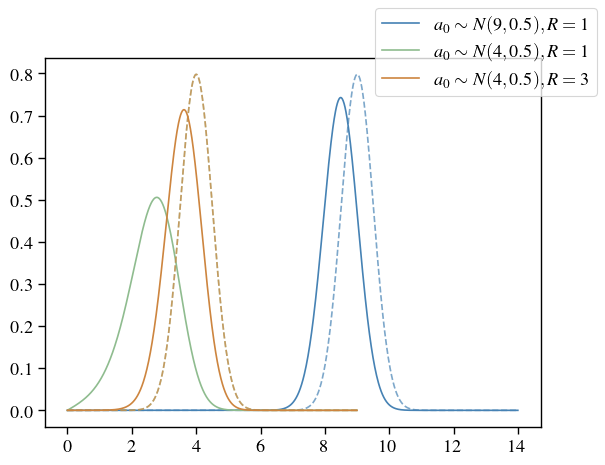

In [9]:
def p_a0_gaussian(a0_ ,amean_ ,std_):
    prefactor = 1/ (np.sqrt(2 * np.pi * std_**2))
    expterm = np.exp(- (a0_ - amean_)**2 / (2 * std_**2))
    return prefactor * expterm

def pa_sigma_a0_gaus_integrand(a0, a, mbh, t, R, amean_ ,std_):
    return pa_sigma(a, mbh, t, a0, R) * p_a0_gaussian(a0 ,amean_ ,std_)

def pa_sigma_a0_gaus(amean_ ,std_,mbh,t,R):
    aupper = amean_ + std_ * 10
    a = np.linspace(0,aupper,1000)
    prior = p_a0_gaussian(a,amean_,std_)
    p = []
    for a_ in a:
        p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,R,amean_ ,std_))[0])
    return a, p, prior

def plot_pa_gaus(amean_ ,std_,mbh,t,R,ax,clr):
    # function for plotting pa, gaussian a0
    # find p(a|mbh)
    a,p,pr = pa_sigma_a0_gaus(amean_ ,std_,mbh,t,R)
    # plot
    ax.plot(a,p,c=clr,label=rf"$a_0\sim N({{{amean_}}},{{{std_}}}),R={R}$")
    ax.plot(a,pr,linestyle="--",c=clr,alpha=0.7)

fig,ax = plt.subplots()
plot_pa_gaus(9,0.5,1e8,2,1,ax,"steelblue")
plot_pa_gaus(4,0.5,1e8,2,1,ax,"darkseagreen")
plot_pa_gaus(4,0.5,1e8,2,3,ax,"peru")
fig.legend();

Check with Monte Carlo

/tmp/ipykernel_747/2926582598.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/(gamma*R)/(a0**2-a**2)/200
/tmp/ipykernel_747/2926582598.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_747/2926582598.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_747/2951682623.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,R,amean_ ,std_))[0])
/tmp/ipykernel_747/3630980390.py:9: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))


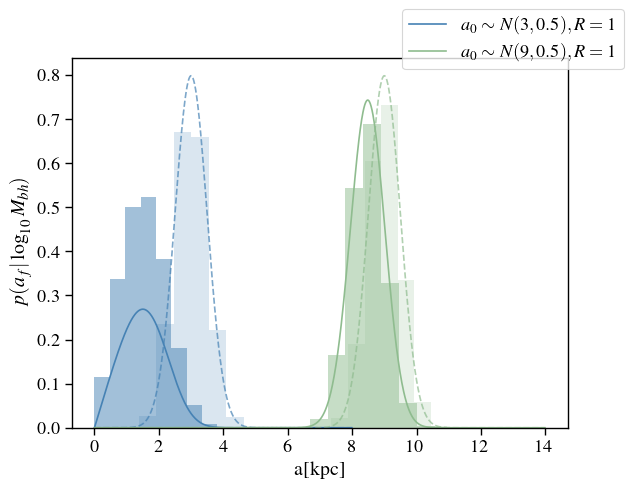

In [10]:
def plot_monte_carlo_gaus_a0(amean_,std_,mbh,t,R,ax,clr):
    N = 10000000
    logmbh = np.log10(mbh)
    # sample a0
    a0 = np.random.normal(loc=amean_,scale=std_,size=N)
    # sample sigma
    logsigma = np.random.normal(loc=1/beta*logmbh-alpha/beta,scale=epsilon/beta,size=N)
    sigma = 10**logsigma*200
    af = np.sqrt(a0**2 - mbh*t/(gamma*R*sigma))
    # plot
    ax.hist(af,density=True,color=clr,alpha=0.5)
    ax.hist(a0,density=True,color=clr,alpha=0.2)
    return af

fig,ax = plt.subplots()
plot_pa_gaus(3,0.5,1e8,2,1,ax,"steelblue")
plot_monte_carlo_gaus_a0(3,0.5,1e8,2,1,ax,"steelblue")

plot_pa_gaus(9,0.5,1e8,2,1,ax,"darkseagreen")
plot_monte_carlo_gaus_a0(9,0.5,1e8,2,1,ax,"darkseagreen")

ax.set_xlabel("a[kpc]")
ax.set_ylabel(r"$p(a_f|\log_{10}{M_{bh}})$")
fig.legend();